## Key Points in Ad Recommendation
- The number of candidates may not be very large.  
- CTR is important, but not only the ranking stage matters.  
- Ads can be ordered by **CTR prediction × bid price**.  
- In traditional ranking, only the order matters rather than the exact CTR values.  
  - For example, [0.9, 0.2, 0.1] vs. [0.6, 0.5, 0.4] does not make a difference as long as the order is preserved.  
- However, in advertising, it is also critical to **predict CTR accurately**, not just preserve ordering, since costs are tied to predictions.  

In [ ]:
!pip install tensorflow-recommenders

In [ ]:
import pandas as pd

rootpath = "/Users/teo/Desktop/AdRecommendationUplift/KuaiRec/data/"

# Load main interactions
df = pd.read_csv(rootpath + "big_matrix.csv", low_memory=False)

# Create is_viewed from watch_ratio
df["is_viewed"] = (df["watch_ratio"] > 1).astype(int)

# Convert date column (YYYYMMDD → YYYY-MM-DD)
df["date"] = pd.to_datetime(df["date"].astype(str), format="%Y%m%d").dt.strftime("%Y-%m-%d")

# Keep only 4 columns
dataset = df[["user_id", "video_id", "date", "is_viewed"]].copy()

print(dataset.head())
print(dataset.shape)

In [5]:
import pandas as pd

In [6]:
dataset = pd.read_parquet(rootpath + 'labels.parquet')
dataset['is_viewed'] = dataset['watch_ratio'] > 1
dataset['is_viewed'] = dataset['is_viewed'].replace({True: 1, False: 0})
dataset.drop('watch_ratio', axis = 1)

,user_id,video_id,date,is_viewed
0,14,148,2020-07-05,0
1,14,183,2020-07-05,1
2,14,3649,2020-07-05,1
3,14,5262,2020-07-05,0
4,14,8234,2020-07-05,0
...,...,...,...,...
4676370,7162,9177,2020-09-01,0
4676371,7162,4987,2020-09-02,1
4676372,7162,7988,2020-09-03,1
4676373,7162,6533,2020-09-04,0


In [ ]:
item_features = pd.read_parquet(rootpath + 'item_features.parquet')
dataset_with_item_features = pd.merge(left=dataset, right=item_features, how='left', on=['video_id', 'date'])
user_features = pd.read_parquet(rootpath + 'user_features.parquet')
dataset_full = pd.merge(left=dataset_with_item_features, right=user_features, how='left', on='user_id')
train_data = dataset_full[dataset_full.date < '2020-08-20'].drop(columns=['date']).dropna().sample(frac=0.1) 
test_data = dataset_full[dataset_full.date >= '2020-08-20'].drop(columns=['date']).dropna().sample(frac=0.1)

---
## Video Ads

### Data Synthesis
- Calculated the ratio of ad clicks (Click-through Rate, CTR)


In [8]:
dataset['is_viewed'].value_counts()

0    3023039
1    1471539
Name: is_viewed, dtype: int64

- Downsample negative data in the training set.  
- Keep the original ratio in the test set since it will be used for calibration.  

In [9]:
positive_train = train_data[train_data.is_viewed == 1]
negative_train = train_data[train_data.is_viewed == 0]
sampled_negative_train = negative_train.sample(frac=0.5)

In [10]:
train = pd.concat([positive_train, sampled_negative_train], axis=0)

In [11]:
train['is_viewed'].value_counts()

1    122861
0    118474
Name: is_viewed, dtype: int64

In [13]:
import tensorflow as tf

In [ ]:
import tensorflow_recommenders as tfrs
import tensorflow as tf

In [16]:
data = tf.data.Dataset.from_tensor_slices(dict(train))

In [17]:
item_continual_features = [
    'video_duration',
    'show_cnt',
    'show_user_num',
    'play_cnt',
    'play_user_num',
    'show_cnt_7D',
    'show_cnt_14D',
    'show_user_num_7D',
    'show_user_num_14D',
    'play_cnt_7D',
    'play_cnt_14D',
    'play_user_num_7D',
    'play_user_num_14D',
]
item_int_cate_features = [
    'video_id',
    'video_width',
    'video_height',
    'video_tag_id',
]
item_string_cate_features = [
    'video_type'
]
user_continual_features = [
    'follow_user_num',
    'fans_user_num',
    'friend_user_num',
    'register_days',
]
user_int_cate_features = [
    'user_id',
    'is_lowactive_period',
    'is_live_streamer',
    'is_video_author',
    'onehot_feat0',
    'onehot_feat1',
    'onehot_feat2',
    'onehot_feat3',
    'onehot_feat4',
    'onehot_feat5',
    'onehot_feat6',
    'onehot_feat7',
    'onehot_feat8',
    'onehot_feat9',
    'onehot_feat10',
    'onehot_feat11',
    'onehot_feat12',
    'onehot_feat13',
    'onehot_feat14',
    'onehot_feat15',
    'onehot_feat16',
    'onehot_feat17',
]
user_string_cate_features = [
    'user_active_degree',
    'follow_user_num_range',
    'fans_user_num_range',
    'friend_user_num_range',
    'register_days_range',

]
user_features = user_continual_features + user_int_cate_features + user_string_cate_features
item_features = item_continual_features + item_int_cate_features + item_string_cate_features
label = 'is_viewed'

In [ ]:
item_int_vocabs = {x: train_data[x].unique() for x in item_int_cate_features} 
item_str_vocabs = {x: train_data[x].unique() for x in item_string_cate_features} 
item_statistics = {x: (train_data[x].mean(), train_data[x].var()) for x in item_continual_features}
user_int_vocabs = {x: train_data[x].unique() for x in user_int_cate_features}
user_str_vocabs = {x: train_data[x].unique() for x in user_string_cate_features}
user_statistics = {x: (train_data[x].mean(), train_data[x].var()) for x in user_continual_features}

In [ ]:
class RepresentLayer(tf.keras.layers.Layer):
    def __init__(self, item_int_vocabs, item_str_vocabs, item_statistics):
        super().__init__()
        self.int_cate_cols = item_int_vocabs.keys()
        self.str_cate_cols = item_str_vocabs.keys()
        self.conti_cols = item_statistics.keys()

        self.concat = tf.keras.layers.Concatenate()


        self.int_representation_layer = self.create_int_representation_layer(item_int_vocabs)
        self.str_representation_layer = self.create_str_representation_layer(item_str_vocabs)
        self.conti_representation_layer = self.create_conti_representation_layer(item_statistics)


    def create_int_representation_layer(self, item_int_vocabs):
        inputs = [tf.keras.Input(shape=(), name=col, dtype=tf.int64) for col in self.int_cate_cols]
        outputs = []
        for x in inputs:
            vocab = item_int_vocabs[x.name]
            vocab_num = vocab.size
            lookup = tf.keras.layers.IntegerLookup(vocabulary=item_int_vocabs[x.name])(x)
            embeddings = tf.keras.layers.Embedding(vocab_num + 1, 8)(lookup)
            outputs.append(embeddings)
        concat = tf.keras.layers.Concatenate()(outputs)
        return tf.keras.Model(inputs, concat) # inputs

    def create_str_representation_layer(self, item_str_vocabs):
        inputs = [tf.keras.Input(shape=(), name=col, dtype=tf.string) for col in self.str_cate_cols]
        outputs = []
        for x in inputs:
            vocab = item_str_vocabs[x.name]
            vocab_num = vocab.size
            lookup = tf.keras.layers.StringLookup(vocabulary=item_str_vocabs[x.name])(x)
            embeddings = tf.keras.layers.Embedding(vocab_num + 1, 8)(lookup)
            outputs.append(embeddings)
        concat = tf.keras.layers.Concatenate()(outputs)
        return tf.keras.Model(inputs, concat)

    def create_conti_representation_layer(self, item_statistics):
        inputs = [tf.keras.Input(shape=(), name=col, dtype=tf.float32) for col in self.conti_cols]
        outputs = []
        for x in inputs:
            mean, var = item_statistics[x.name]
            normalized = tf.keras.layers.Normalization(axis=-1, mean=mean, variance=var)(tf.expand_dims(x, axis=1))
            outputs.append(normalized)
        concat = tf.keras.layers.Concatenate()(outputs)
        return tf.keras.Model(inputs, concat)


    def call(self, inputs):

        x_conti = self.conti_representation_layer({
            key: inputs[key]
            for key in self.conti_cols
        })
        x_int_cate = self.int_representation_layer({
            key: inputs[key]
            for key in self.int_cate_cols
        })
        x_str_cate = self.str_representation_layer({
            key: inputs[key]
            for key in self.str_cate_cols
        })


        return tf.concat([x_conti, x_int_cate, x_str_cate], axis=-1)

In [21]:
class RankingModel(tfrs.models.Model):

  def __init__(self, item_int_vocabs, item_str_vocabs, item_statistics,
               user_int_vocabs, user_str_vocabs, user_statistics,
               user_features, item_features):
    super().__init__()
    self.candidate_model = RepresentLayer(item_int_vocabs, item_str_vocabs, item_statistics)
    self.query_model = RepresentLayer(user_int_vocabs, user_str_vocabs, user_statistics)
    self.user_features = user_features
    self.item_features = item_features
    self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=32,
          kernel_initializer="glorot_uniform")
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    self.dense1 = tf.keras.layers.Dense(units=64, activation='relu')
    self.batchnorm2 = tf.keras.layers.BatchNormalization()
    self.dense2 = tf.keras.layers.Dense(units=32, activation='relu')
    self.dropout2 = tf.keras.layers.Dropout(0.1)

    self.final = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                                       metrics=[tf.keras.metrics.AUC(name='prc', curve='PR')])

  def call(self, features, train=False) -> tf.Tensor:
    query_embeddings = self.query_model({
        key: features[key]
        for key, val in features.items()
        if key in self.user_features
    })
    item_embeddings = self.candidate_model({
        key: features[key]
        for key, val in features.items()
        if key in self.item_features
    })
    x = tf.concat([query_embeddings, item_embeddings], axis=-1)
    cross = self._cross_layer(x)
    x1 = self.dense1(self.batchnorm1(cross))
    x2 = self.dense2(self.batchnorm2(x1))
    logit = self.final(x2)
    if train:
        logit
    return tf.sigmoid(logit)

  def compute_loss(self, features, training=False) -> tf.Tensor:
    labels = features.pop("is_viewed")

    pred = self(features, training)

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=pred)


In [ ]:
cached_train = (
    data.map(lambda x: {
        key: tf.cast(value, tf.float32)
        if key in item_continual_features + user_continual_features + [label] else value
        for key, value
        in x.items()
    })
    .shuffle(300_000).batch(512).cache() 
)

In [23]:
model = RankingModel(item_int_vocabs, item_str_vocabs, item_statistics,
                      user_int_vocabs, user_str_vocabs, user_statistics,
                      user_features, item_features)

In [24]:
model.compile(optimizer='adam')

In [25]:
ranking_history = model.fit(
    cached_train,
    epochs=1,
    verbose=1)

472/472 [==============================] - 134s 164ms/step - prc: 0.7591 - loss: 0.6338 - regularization_loss: 0.0000e+00 - total_loss: 0.6338


In [26]:
test_ds = (
    tf.data.Dataset.from_tensor_slices(dict(test_data))
        .map(lambda x: {
                key: tf.cast(value, tf.float32)
                if key in item_continual_features + user_continual_features + [label] else value
                for key, value
                in x.items()
        })
        .batch(512)
        .cache()
)

In [27]:
predictions = model.predict(test_ds)

97/97 [==============================] - 8s 75ms/step


In [28]:
test_data['prediction'] = predictions

In [29]:
test_data[test_data.is_viewed == 1][['is_viewed', 'prediction']]

,is_viewed,prediction
3733486,1,0.417374
654306,1,0.003195
4258030,1,0.998864
1891715,1,0.999053
315993,1,0.007917
...,...,...
1109203,1,0.090159
2064472,1,0.997323
800960,1,0.000650
584112,1,0.000017


In [ ]:
test_data.to_parquet(rootpath + 'predicted_result')

In [30]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [31]:
test_data['is_viewed'].to_numpy()

array([1, 0, 0, ..., 1, 0, 0])

In [32]:
test_data['prediction'].to_numpy()

array([4.1737384e-01, 9.9969864e-01, 9.9379649e-06, ..., 7.5457090e-01,
       7.7838880e-10, 7.0112603e-11], dtype=float32)

In [35]:
fraction_of_positives, mean_predicted_value = calibration_curve(
    test_data['is_viewed'].to_numpy(),
    test_data['prediction'].to_numpy(), n_bins=40)

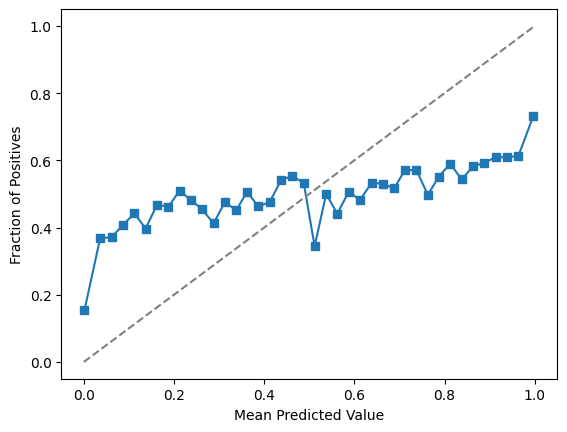

In [ ]:
plt.plot(mean_predicted_value, fraction_of_positives, 's-')
plt.plot([0, 1], [0, 1], '--', color='gray')  
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.show()

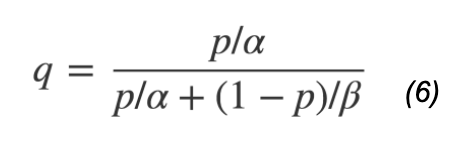

In [37]:
test_data['calibration'] = (test_data['prediction'] / (test_data['prediction'] + ((1- test_data['prediction']) / 0.5)))

In [38]:
test_data[['is_viewed', 'prediction', 'calibration']]

,is_viewed,prediction,calibration
3733486,1,4.173738e-01,2.637223e-01
864661,0,9.996986e-01,9.993975e-01
1297676,0,9.937965e-06,4.969007e-06
1316694,0,1.622916e-06,8.114586e-07
4430835,0,7.937362e-26,3.968681e-26
...,...,...,...
1802352,0,9.993236e-01,9.986481e-01
584112,1,1.692522e-05,8.462684e-06
3132444,1,7.545709e-01,6.058723e-01
1367326,0,7.783888e-10,3.891944e-10


In [41]:
fraction_of_positives2, mean_predicted_value2 = calibration_curve(test_data['is_viewed'], test_data['calibration'], n_bins=40)

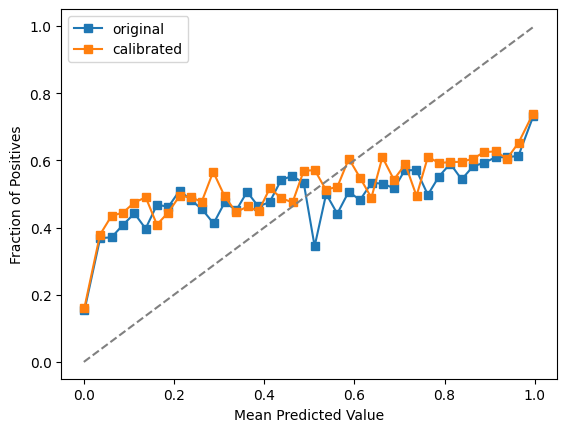

In [ ]:
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='original')
plt.plot(mean_predicted_value2, fraction_of_positives2, 's-', label='calibrated')

plt.plot([0, 1], [0, 1], '--', color='gray')  
plt.xlabel('Mean Predicted Value')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()